### Capstone Project
By David Penny

#### Goals:
1. Be able to label reviews as suspicious, "1" or not-suspicious, "0"
2. Be able to label a group of reviews as suspicious, "1" or not-suspicious, "0"
- Start simple, make mini corpuses of hand copy + pasted reviews.
- Try out BeautifulSoup to do the above.
3. Be able to label a product as suspicious, "1" or not-suspicious, "0"

Notes:
- Fakespot unreliable? ReviewMeta is much more detailed.

#### Algorithm

Algorithm (ReviewMeta):
- deleted_reviews
- reviewer_ease
- rating_trend
- unverified_purchases
- word_count_comparison
- phrase_repetition
- suspicious_reviewers (one-hit wonders, never-verified reviewers, single-day reviewers)
- overlapping_review_history
- brand_repeats
- incentivized_reviews

Algorithm (SMU Data Science Review)
- sentiment_to_average_rating
- user_rating
- text_total_sentiment
- num_words_no_stop
- text_threat_score (probability that the review has threats)
- Text Readability Score
- 
 


## 1. Basics and Data Prep.

In [4]:
#Lets import our necessary packages
import boto3
import botocore
import json
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

In [20]:
# Filter warnings
import warnings
warnings.filterwarnings('ignore')

In [21]:
glue = boto3.client('glue')
s3 = boto3.client('s3')
s3_resource = boto3.resource('s3')

session = boto3.session.Session()
region = session.region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')

bucket = 'escience-workshop-dp'
amazon_review_bucket = 'amazon-reviews-pds'

pd.set_option('display.max_colwidth', -1)
%matplotlib inline

#### Step 1: [Create S3 Bucket](https://docs.aws.amazon.com/AmazonS3/latest/gsg/CreatingABucket.html)

We will create an S3 bucket that will be used throughout the project for storing data.

[s3.create_bucket](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3.html#S3.Client.create_bucket) boto3 documentation

In [3]:
def create_bucket(bucket):
    import logging

    try:
        s3.create_bucket(Bucket=bucket, CreateBucketConfiguration={'LocationConstraint': region})
    except botocore.exceptions.ClientError as e:
        logging.error(e)
        return 'Bucket {0} could not be created.'.format(bucket)
    return 'Created {0} bucket.'.format(bucket)

In [4]:
create_bucket(bucket)

ERROR:root:An error occurred (InvalidLocationConstraint) when calling the CreateBucket operation: The specified location-constraint is not valid


'Bucket escience-workshop-dp could not be created.'

#### Step 2: [Download Amazon Product Reviews](https://boto3.amazonaws.com/v1/documentation/api/latest/guide/s3-example-download-file.html) 

We will download the reviews from the Amazon Product Review dataset available on the [AWS Open Data Registry](https://registry.opendata.aws/amazon-reviews/).

In [4]:
try:
    s3_resource.Bucket(amazon_review_bucket).download_file('tsv/amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz', 'amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

#### Step 3: Unzip Amazon Video Reviews



In [5]:
!gzip -d amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz

amazon_reviews_us_Mobile_Electronics_v1_00.tsv already exists -- do you wish to overwrite (y or n)? ^C


In [6]:
!ls -la

total 265144
drwxr-xr-x  21 davepenny  staff       672 11 Jun 16:25 .
drwxr-xr-x  15 davepenny  staff       480  6 Jun 09:52 ..
drwxr-xr-x   8 davepenny  staff       256 11 Jun 00:43 .ipynb_checkpoints
-rw-r--r--   1 davepenny  staff   1996403 11 Jun 00:43 Capstone_Project_David_Penny 200610.ipynb
-rw-r--r--   1 davepenny  staff   1171333 11 Jun 16:25 Capstone_Project_David_Penny 200611.ipynb
-rw-r--r--   1 davepenny  staff   1783063 10 Jun 01:13 Capstone_Project_David_Penny.ipynb
-rw-r--r--   1 davepenny  staff  58221236  6 Jun 10:33 amazon_reviews_us_Mobile_Electronics_v1_00.tsv
-rw-r--r--   1 davepenny  staff  22870508 11 Jun 16:24 amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz
-rw-r--r--   1 davepenny  staff     16110  6 Jun 13:35 catanddog.ipynb
drwxr-xr-x   3 davepenny  staff        96  6 Jun 09:46 cfn
-rw-r--r--   1 davepenny  staff     14791  6 Jun 09:46 ec2_cfn_systems_manager.ipynb
-rw-r--r--   1 davepenny  staff     14893  6 Jun 09:46 ground_truth_cat_dog.ipynb
-rw-r--r--

## 2. Data Cleanup and Prep.

#### Step 1: View raw tsv file

We will use [Pandas](https://pandas.pydata.org/) [`read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) method to load the tsv into a [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). The dataset contains a number of columns associated with each review. For this exercise you will only be concerned with the `review_body` and `star_rating` columns. The `star_rating` is between 1-5 and the `review` is a free form text field. You will then use the DataFrame's [`head()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) method to see the first few rows.

In [54]:
df = pd.read_csv('data/amazon_reviews_us_Mobile_Electronics_v1_00.tsv', sep='\t', error_bad_lines=False)
df_dirty = df
df_original = df
df.head().transpose();

b'Skipping line 35246: expected 15 fields, saw 22\n'
b'Skipping line 87073: expected 15 fields, saw 22\n'


#### Step 2: View Data types of the columns in the data set

To see the data types of each column you can use the [`dtypes`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html) function. Click [here](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html#basics-dtypes) for more information on the basic dtypes supported.

In [55]:
df_dirty.dtypes

marketplace           object
customer_id            int64
review_id             object
product_id            object
product_parent         int64
product_title         object
product_category      object
star_rating          float64
helpful_votes        float64
total_votes          float64
vine                  object
verified_purchase     object
review_headline       object
review_body           object
review_date           object
dtype: object

#### Step 3:  Create new DataFrame for only columns needed

Below we will will keep only the `review_body` and `star_rating` fields for our dataset. YOu can use the [loc](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html) method to access just the columns and rows you need. You will also filter out the neutral reviews which we are signifying as reviews with a `3` star rating to make more definitive the positive vs. negative reviews.

In [56]:
df_dirty = df_dirty.loc[:, ['review_body', 'star_rating']]
df_dirty = df_dirty.query('star_rating != 3.0')
df_dirty.head()

,review_body,star_rating
0,"As advertised. Everything works perfectly, I'm...",5.0
1,it's great,5.0
2,These work great and fit my life proof case fo...,5.0
3,Work very well but couldn't get used to not he...,4.0
4,"Be careful with these products, I have bought ...",2.0


#### Step 4: Add new column `sentiment` based on `star_rating`

Next, we will use the [apply]() method to apply a function to each row in the DataFrame adding a new column `sentiment`. This will make it easier to visualize the data.

In [57]:
def get_sentiment(value):
    if value > 3:
        return 1
    else:
        return 0

In [58]:
df_dirty['sentiment'] = df_dirty['star_rating'].apply(get_sentiment)

In [59]:
df_dirty.head()

,review_body,star_rating,sentiment
0,"As advertised. Everything works perfectly, I'm...",5.0,1
1,it's great,5.0,1
2,These work great and fit my life proof case fo...,5.0,1
3,Work very well but couldn't get used to not he...,4.0,1
4,"Be careful with these products, I have bought ...",2.0,0


#### Step 5. Basic Cleaning
There are a number of ways to clean the daatset you are working with. You will go through a few exercises looking at the data and perfoming actions based on the results to cleanse the data. The first thing you want to do is look at the [`unique`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.unique.html) `star_rating` values. You will notice there are reviews with a `nan` rating so we will want to remove those using the [`dropna`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) method.

We can visualize the counts to quickly see the breakout by `star_rating`. For that you will be using [seaborn](https://seaborn.pydata.org/).

Next we want to **de-duplicate** the rows. It is necessary to remove duplicates in order to get unbaised results. Checking duplicates based on `review_body` and `star_rating`. If all values are equal then we will remove those records.

At this time we can also transform the 'review_body' from it's regular form, with capital letters to the pure lowercase text. We can also see below we have ratings with a `nan` value meaning no `star_rating` was giving for the review. We will drop the `nan` reviews as well to clean up the data set.

In [60]:
df_dirty.star_rating.unique()

array([ 5.,  4.,  2.,  1., nan])

In [61]:
def display_NA_counts(the_df):
    null_series = the_df.isna().sum(axis=0)
    display(null_series[null_series > 0])

In [62]:
display_NA_counts(df_dirty)

review_body    3
star_rating    2
dtype: int64

In [63]:
df_dirty.shape

(95132, 3)

In [64]:
df_dirty.dropna(inplace=True)

#### Step 6: Visualize the review counts

5.0    52197
4.0    18063
1.0    17571
2.0     7298
Name: star_rating, dtype: int64


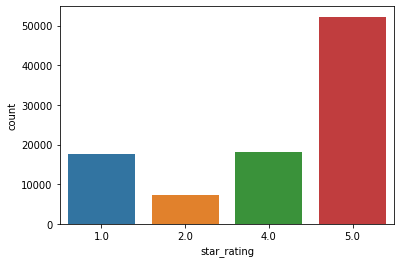

In [65]:
print(df_dirty['star_rating'].value_counts())
sns.countplot(x='star_rating', data=df_dirty)

#### Step 7: Drop duplicates and set proper data types

In [66]:
import string
df_dirty = df_dirty.drop_duplicates(subset={'review_body', 'star_rating'})

df_dirty.dropna(inplace=True)
df_dirty.loc[:, 'star_rating'] = df_dirty['star_rating'].astype(int)
df_dirty.loc[:, 'review_body'] = df_dirty['review_body'].astype(str).str.lower()
df_dirty.head()

,review_body,star_rating,sentiment
0,"as advertised. everything works perfectly, i'm...",5,1
1,it's great,5,1
2,these work great and fit my life proof case fo...,5,1
3,work very well but couldn't get used to not he...,4,1
4,"be careful with these products, i have bought ...",2,0


1    67999
0    24720
Name: sentiment, dtype: int64


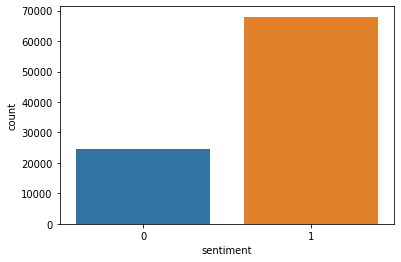

In [67]:
print(df_dirty['sentiment'].value_counts())
sns.countplot(x='sentiment', data=df_dirty)

#### Step 8: Python [Wordcloud](http://amueller.github.io/word_cloud/) Visualization

Another visualization technique you can use to see what words stand out in the data set is to build a Wordcloud visualization. First, we will use pip to install the library nad then build a simple function to plot the words.

In [68]:
#Remove # on fist run
#!python -m pip install wordcloud

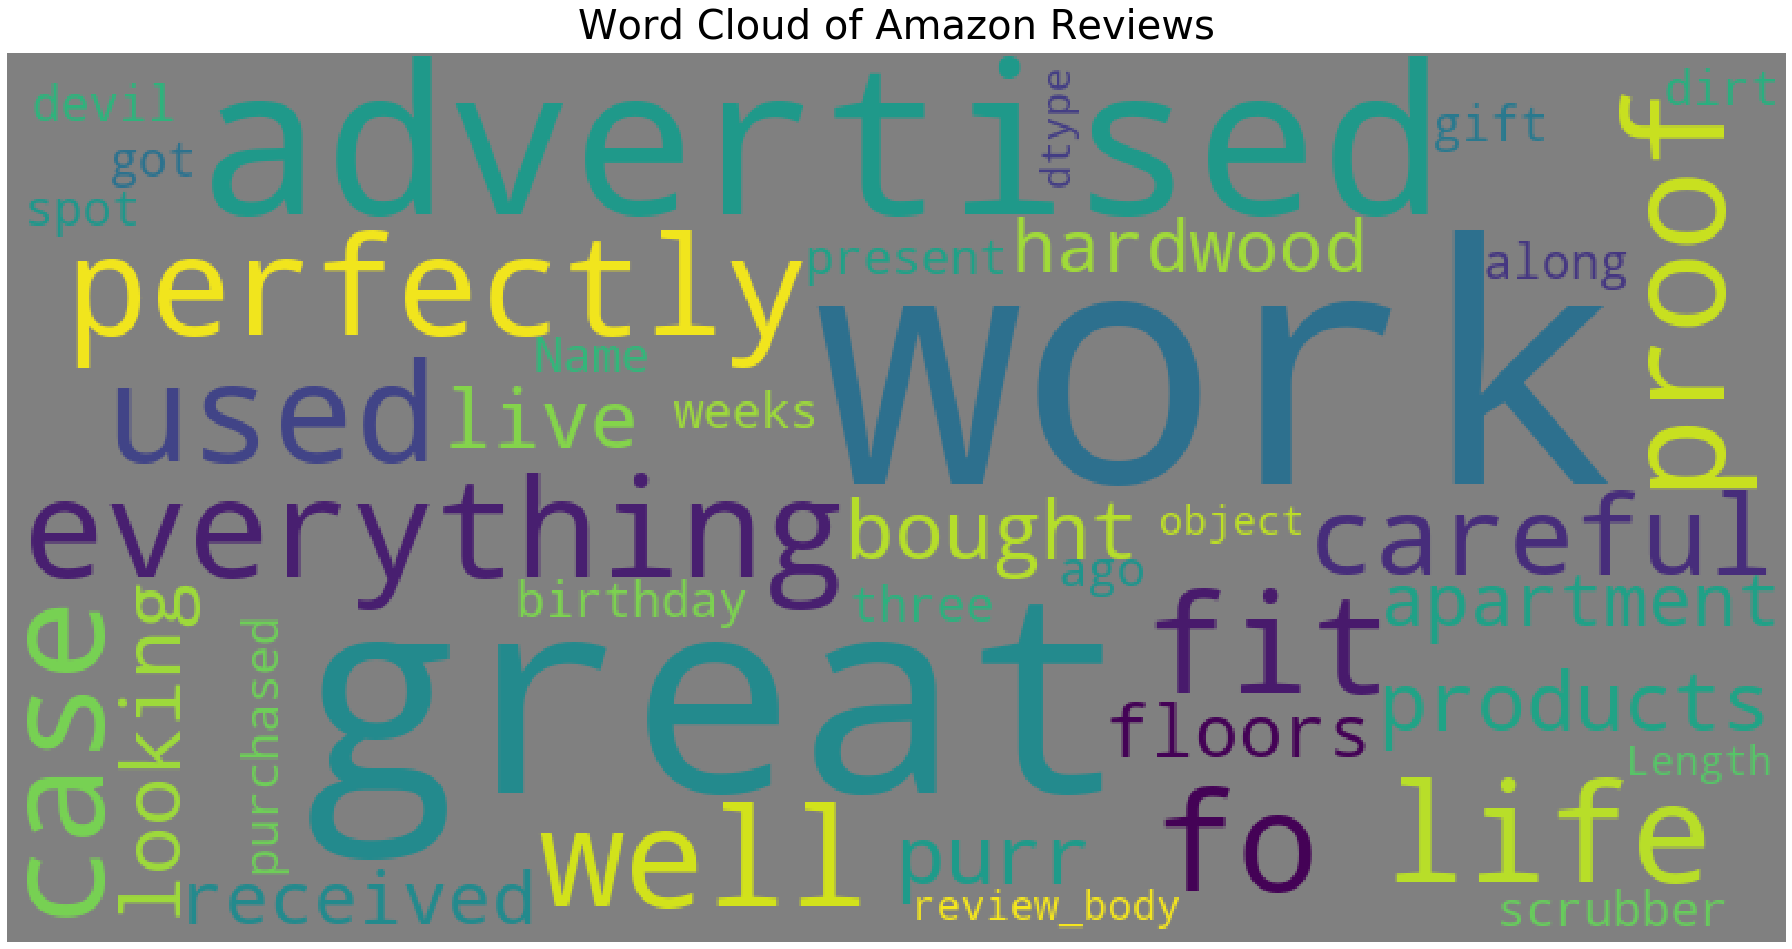

In [69]:
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=150, figure_size=(25.0,15.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(background_color='gray',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 50,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(df_dirty['review_body'], title="Word Cloud of Amazon Reviews")

You can see in the wordcloud `br` which typically means there is HTML markeup in the `review_body`. We want to clean the reviews by removing the markup as well. We will use [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to remove the markup. 

In [70]:
import bs4
df_dirty['review_body'] = df_dirty['review_body'].apply(lambda x: bs4.BeautifulSoup(x, 'lxml').get_text())

/Users/davepenny/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:389: UserWarning: "https://youtu.be/vbt_w7s_z14" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/davepenny/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:314: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [71]:
#Data is clean!
df_small = df_dirty

#### Step 9: Discover 

In [72]:
import string

## Number of words in the text ##
df_small["num_words"] = df_small["review_body"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
df_small["num_unique_words"] = df_small["review_body"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
df_small["num_chars"] = df_small["review_body"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
df_small["num_stopwords"] = df_small["review_body"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## Number of punctuations in the text ##
df_small["num_punctuations"] = df_small['review_body'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Average length of the words in the text ##
df_small["mean_word_len"] = df_small["review_body"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [73]:
df_small.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
star_rating,92719.0,3.819832,1.586057,1.0,2.000000,5.00000,5.0,5.0
sentiment,92719.0,0.733388,0.442190,0.0,0.000000,1.00000,1.0,1.0
num_words,92719.0,63.373063,92.597331,1.0,22.000000,36.00000,72.0,2801.0
num_unique_words,92719.0,45.077427,45.957879,1.0,20.000000,31.00000,55.0,938.0
num_chars,92719.0,338.568384,507.499220,1.0,117.000000,191.00000,378.0,15713.0
num_stopwords,92719.0,31.374260,45.623195,0.0,10.000000,18.00000,36.0,1432.0
num_punctuations,92719.0,10.071873,17.958889,0.0,3.000000,5.00000,11.0,695.0
mean_word_len,92719.0,4.373641,0.718084,1.0,4.013699,4.29092,4.6,55.0


In [74]:
review_body_summary = df_small

In [75]:
review_body_summary.to_csv('review_body_summary.csv');

## 3. Visualizations and EDA

#### Step 1: Basic Graphs

I would like to see if any patterns are present visually in the data before we get into any deeper analysis.

In [76]:
df_small = pd.read_csv('review_body_summary.csv', error_bad_lines=False)

In [77]:
df_small.head()

,Unnamed: 0,review_body,star_rating,sentiment,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,mean_word_len
0,0,"as advertised. everything works perfectly, i'm...",5,1,26,24,139,12,6,4.384615
1,1,it's great,5,1,2,2,10,1,1,4.500000
2,2,these work great and fit my life proof case fo...,5,1,13,13,60,5,0,3.692308
3,3,work very well but couldn't get used to not he...,4,1,20,20,101,11,2,4.100000
4,4,"be careful with these products, i have bought ...",2,0,24,23,141,13,6,4.916667


In [78]:
df_small.drop(['Unnamed: 0'], inplace = True, axis=1)

In [79]:
df_small.head()

,review_body,star_rating,sentiment,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,mean_word_len
0,"as advertised. everything works perfectly, i'm...",5,1,26,24,139,12,6,4.384615
1,it's great,5,1,2,2,10,1,1,4.500000
2,these work great and fit my life proof case fo...,5,1,13,13,60,5,0,3.692308
3,work very well but couldn't get used to not he...,4,1,20,20,101,11,2,4.100000
4,"be careful with these products, i have bought ...",2,0,24,23,141,13,6,4.916667


In [80]:
# df_small = df_save

# #Let's bring back in verified_purchase
# df_small = df_small.join(df_original['verified_purchase'])

# #Let's convert it to binary
# df_small['verified_purchase'] = df_small['verified_purchase'].map({'Y': 1, 'N': 0})

# df_small.head(1)

In [81]:
#Sanity Check
display_NA_counts(df_small);

Series([], dtype: int64)

In [82]:
df_small.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92719 entries, 0 to 92718
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   review_body       92719 non-null  object 
 1   star_rating       92719 non-null  int64  
 2   sentiment         92719 non-null  int64  
 3   num_words         92719 non-null  int64  
 4   num_unique_words  92719 non-null  int64  
 5   num_chars         92719 non-null  int64  
 6   num_stopwords     92719 non-null  int64  
 7   num_punctuations  92719 non-null  int64  
 8   mean_word_len     92719 non-null  float64
dtypes: float64(1), int64(7), object(1)
memory usage: 6.4+ MB


In [83]:
#df is huge! Lets sample a portion for speedy results
df_for_pair_plot = df_small.sample(frac=.05, random_state=42)
df_for_pair_plot.drop(['review_body'], inplace = True, axis=1)

/Users/davepenny/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/davepenny/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/davepenny/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/davepenny/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


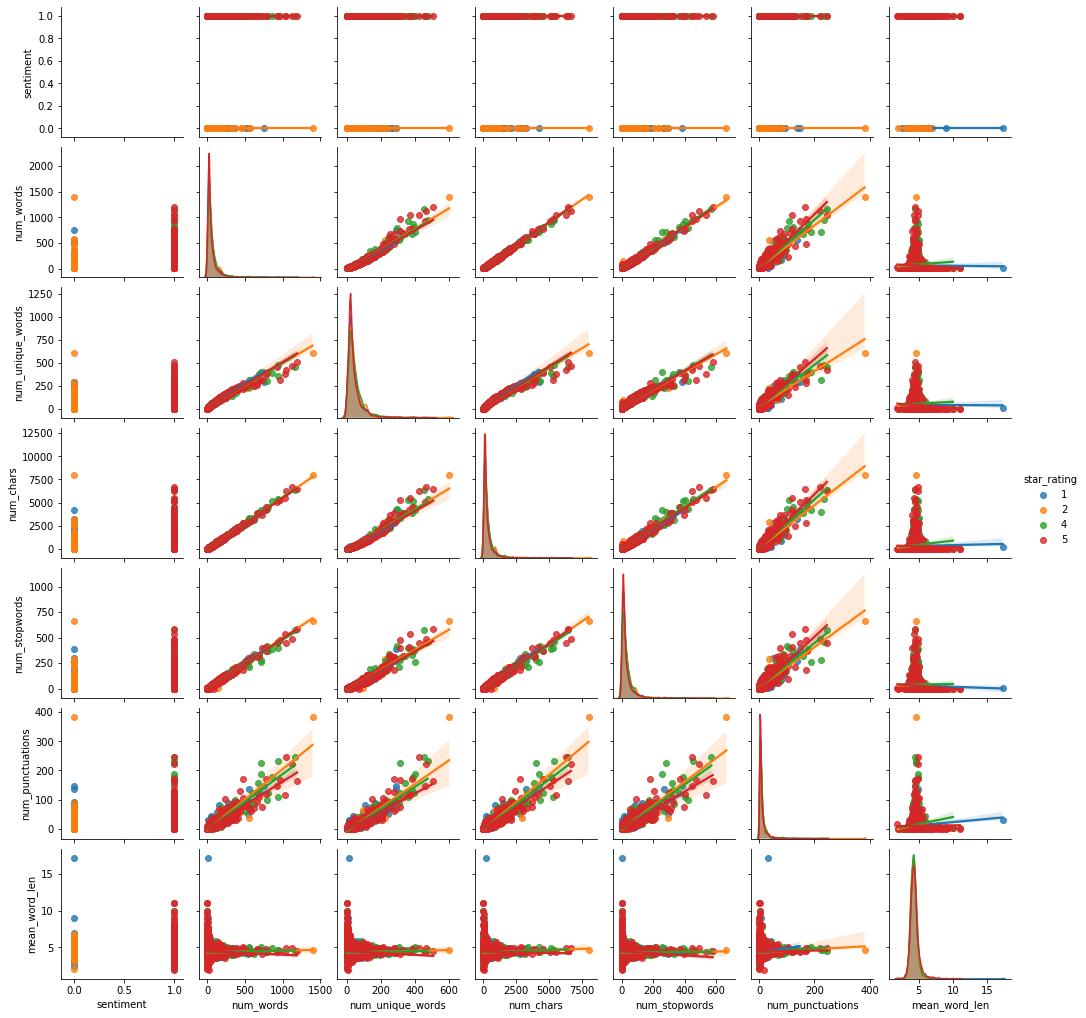

In [84]:
# Let's start by looking at the data using a pairs plot
sns.pairplot(df_for_pair_plot, height=2, kind="reg", hue='star_rating');

While there is lots of very interesting things going on here, I think anything involving "mean_word_length" is very interesting. Let's look more into that:

(0, 10)

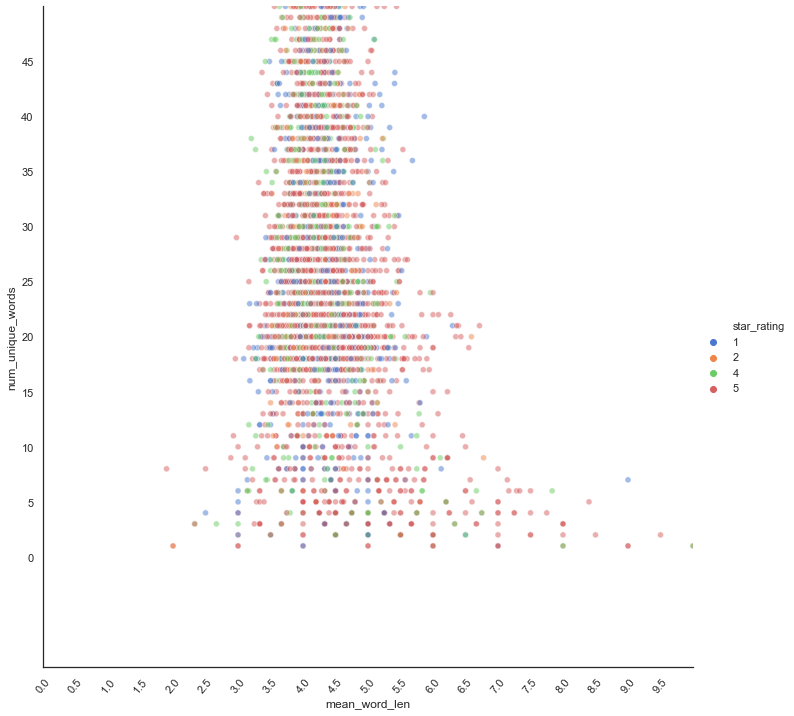

In [85]:
sns.set(style="white")

# Plot mean_word_len against num_unique_words with other semantics
sns.relplot(x="mean_word_len", y="num_unique_words", hue="star_rating",
            sizes=(40, 100), alpha=.5, palette="muted",
            height=10,  data=df_for_pair_plot)
#Shape the output a bit
plt.xticks(np.arange(0, 10, step=.5), rotation=50)
plt.yticks(np.arange(0, 50, step=5), rotation=0)
plt.ylim(-10, 50)
plt.xlim(0, 10)


Near the bottom of the dataset, there is some incredibly unique shapes appearing, lets make an interactive plot to be able to gain insights exactly where we are interested:

In [86]:
from bokeh.plotting import figure, output_file, show

N = 4000
x=df_for_pair_plot["mean_word_len"]
y=df_for_pair_plot["num_unique_words"]
radii = np.random.random(size=N) * 1
colors = ["#%02x%02x%02x" % (int(r), 
                             int(g), 
                             150) for r, 
                              g in zip(50+2*x, 30+2*y)]

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

p = figure(tools=TOOLS)

p.scatter(x, y, 
          fill_color=colors, 
          fill_alpha=0.6,
          line_color=None)

#output_file("color_scatter.html", title="color_scatter.py example")

show(p)  # open a browser

Lets peek into the following points
- 'num_unique_words == 2 and mean_word_len == 4.5'
- num_unique_words == 2 and mean_word_len == 3.5
- num_unique_words == 2 and mean_word_len == 5.5

Something very interesting occurs when the mean_word_length is at 3.5. Compared to just setting num_unique_words <= 2, when we add in the other constraint, the reviews become very suspicious.

In [663]:
df_new = df_small.query('num_unique_words == 2 and mean_word_len == 4.5')
df_new.head(30)

,review_body,star_rating,sentiment,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,mean_word_len
1,it's great,5,1,2,2,10,1,1,4.50
77,two failed,1,0,2,2,10,0,0,4.50
131,good value,4,1,2,2,10,0,0,4.50
336,good cords,5,1,2,2,10,0,0,4.50
338,good value,5,1,2,2,10,0,0,4.50
764,great item,5,1,2,2,10,0,0,4.50
876,good stuff,5,1,2,2,10,0,0,4.50
1103,works well,5,1,2,2,10,0,0,4.50
1128,cheap case,1,0,2,2,10,0,0,4.50
1134,good cords,5,1,2,2,10,0,0,4.50


In [666]:
df_new2 = df_small.query('num_unique_words == 2 and mean_word_len == 3.5')
df_new2.head(30)

,review_body,star_rating,sentiment,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,mean_word_len
1292,good buy,5,1,2,2,8,0,0,3.50
1446,good !!!,5,1,2,2,8,0,3,3.50
1480,lovin it,5,1,2,2,8,1,0,3.50
1488,not good,1,0,2,2,8,1,0,3.50
1845,love it.,5,1,2,2,8,0,1,3.50
2070,nice fit,5,1,2,2,8,0,0,3.50
3161,love it!,5,1,2,2,8,0,1,3.50
3670,great !!,5,1,2,2,8,0,2,3.50
3674,love it!,5,1,2,2,8,0,1,3.50
3678,fit good,4,1,2,2,8,0,0,3.50


In [38]:
df_new3 = df_small.query('num_unique_words == 2 and mean_word_len == 5')
df_new3.head(30)

,review_body,star_rating,sentiment,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,mean_word_len
30,life savers,5,1,2,2,11,0,0,5.0
102,works great,5,1,2,2,11,0,0,5.0
168,works fine.,5,1,2,2,11,0,1,5.0
552,bad product,1,0,2,2,11,0,0,5.0
562,work great!,4,1,2,2,11,0,1,5.0
623,works great,5,1,2,2,11,0,0,5.0
823,a++ wires!!,5,1,2,2,11,0,4,5.0
998,great cover,5,1,2,2,11,0,0,5.0
1011,perfect fit,5,1,2,2,11,0,0,5.0
1315,no problems,5,1,2,2,11,1,0,5.0


In [684]:
df_new4 = df_small.query('num_unique_words <= 2')
df_new4.head(30)

,review_body,star_rating,sentiment,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,mean_word_len
1,it's great,5,1,2,2,10,1,1,4.50
12,love it,5,1,2,2,7,1,0,3.00
13,sucks,1,0,1,1,5,0,0,5.00
22,great,5,1,1,1,5,0,0,5.00
30,life savers,5,1,2,2,11,0,0,5.00
40,"x x vc""ccc",5,1,3,2,10,0,1,2.67
67,satisfied,5,1,1,1,9,0,0,9.00
71,excelente producto,1,0,2,2,18,0,0,8.50
73,awesome product,5,1,2,2,15,0,0,7.00
75,nice,5,1,1,1,4,0,0,4.00


While these areas were interesting, they don't lead to conclusive evidence of falsified reviews. Simply seems to be a result of how the english language is written. 

We lack data labels in regards to if this data is falsified or not. Thus, clustering is a good alternative for classification.

Next steps:
- Try looking at GMM with 2 clusters.
- Try looking at K-Means with 2 clusters.
- Try T-sne

## 4. Further Cleanup

In [90]:
## Truncate some extreme values for better visuals, think about balancing positive vs negative reviews ##
df_small = pd.read_csv('review_body_summary.csv', error_bad_lines=False)
df_small = df_small.query('num_words <= 500 and num_punctuations < 300')

As noted before, we have some serious class imbalance, lets use resample to get a better representation of our data.

1    67433
0    24594
Name: sentiment, dtype: int64


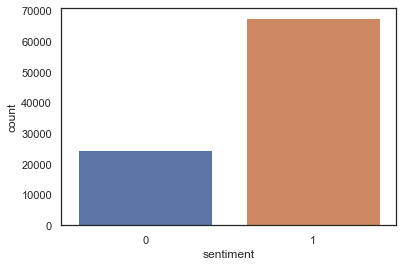

In [91]:
print(df_small['sentiment'].value_counts())
sns.countplot(x='sentiment', data=df_small)

1    24594
0    24594
Name: sentiment, dtype: int64


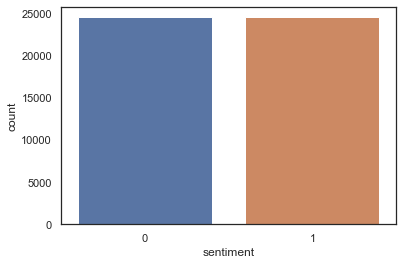

In [92]:
from sklearn.utils import resample

positive = df_small[df_small['sentiment']==1]
negative = df_small[df_small['sentiment']==0]

positive_downsampled = resample(positive,
                                replace = False, # sample without replacement
                                n_samples = len(negative), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([positive_downsampled, negative])

df_small_downsampled = downsampled

# checking counts
print(downsampled['sentiment'].value_counts())
sns.countplot(x='sentiment', data=downsampled)

Good. We've now fixed our class imbalances and have now truncated some outliers.

In [93]:
df_final = df_small

In [94]:
df_final.to_csv('data/df_final.csv');

## 5. Clustering

In [95]:
df_final = pd.read_csv('data/df_final.csv', error_bad_lines=False)

In [96]:
#df is huge! Lets sample a portion for speedy results
df_for_clustering = df_final.sample(frac=.2, random_state=42)

In [97]:
df_for_clustering.drop(['review_body'], inplace = True, axis=1)

In [98]:
df_for_clustering.drop(['Unnamed: 0'], inplace = True, axis=1)

#### Gaussian Model

<mark> Take a look at more than two cluster, remove num_words, look at reading_complexity (prebuilt measures) Vectorize reviews, TSNE to get to small d space, look at LDA (latent dirichlet allocation) <mark>
    

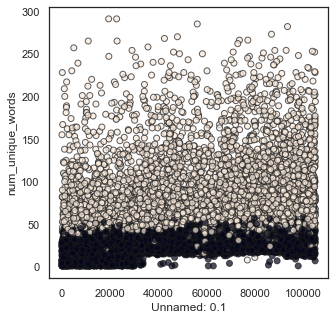

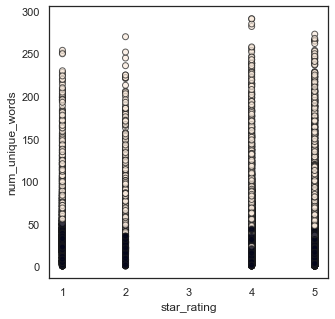

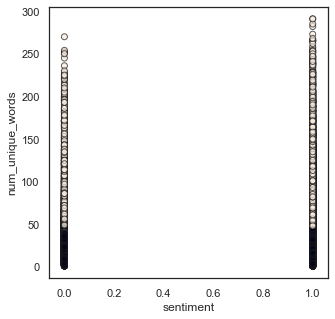

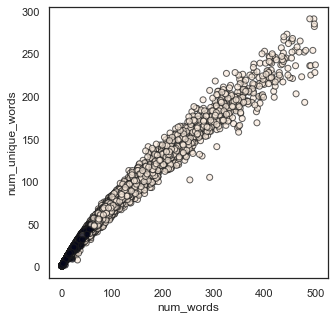

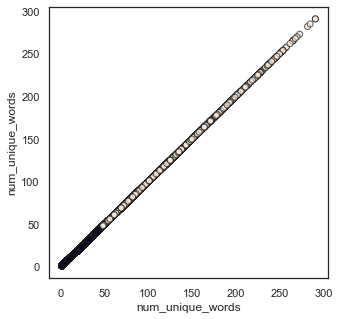

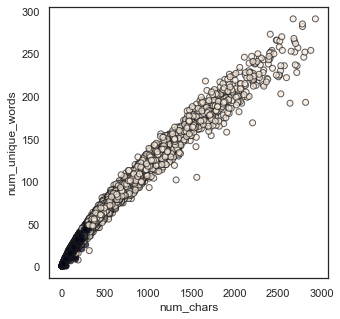

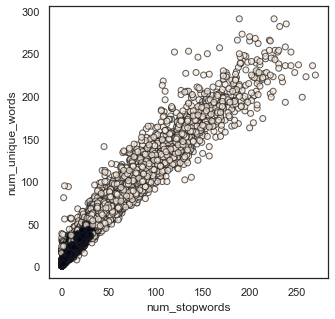

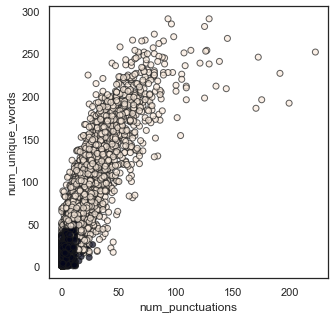

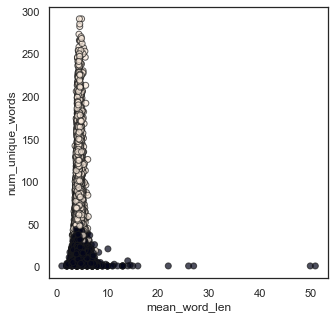

In [99]:
from sklearn.mixture import GaussianMixture

X = df_for_clustering
y = df_for_clustering['sentiment']

#Build and fit the model
my_gmm = GaussianMixture(n_components=2, covariance_type='full')
my_gmm.fit(X)

#Getting the labels
pred_labels_gmm = my_gmm.predict(X)

for column in df_for_clustering:
    #Plot the predictions
    plt.figure(figsize=[5,5])
    plt.scatter(x = df_for_clustering[column],
                y = df_for_clustering['num_unique_words'],
                c=pred_labels_gmm, 
                edgecolor='k',
                alpha=0.7)
    plt.xlabel(column)
    plt.ylabel('num_unique_words')
    plt.show();

#### K-Means Model

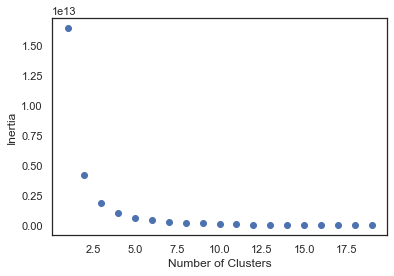

In [100]:
k_range = np.arange(1,20)

inertia_list = []

for k in k_range :
    
    #Specify the model
    my_kmm = KMeans(n_clusters = k)
    my_kmm.fit(df_for_clustering)
    
    inertia_list.append(my_kmm.inertia_)
    
plt.figure()
plt.scatter(k_range,inertia_list)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show();

In [47]:
from sklearn.cluster import KMeans

#Specify the model
my_kmm = KMeans(n_clusters = 3)
#Fit the model to the data
my_kmm.fit(df_for_clustering);

#Annotate the data points with the K-Means prediction
pred_labels_kmm = my_kmm.labels_

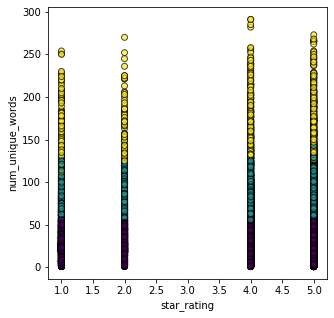

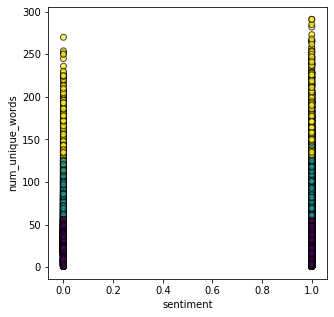

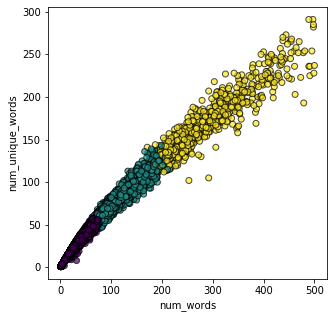

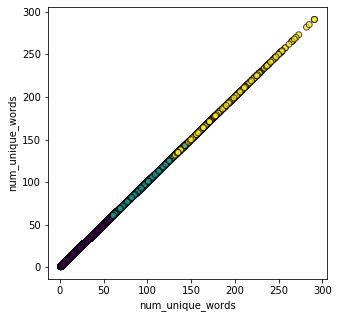

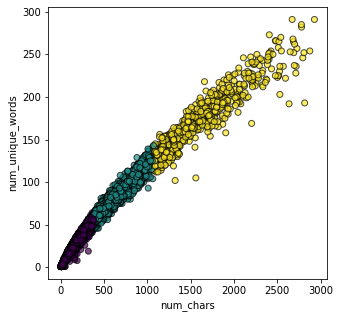

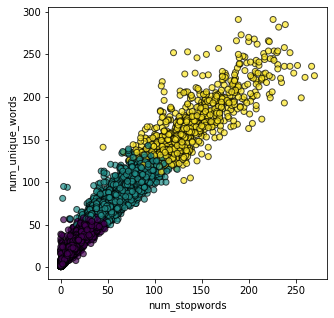

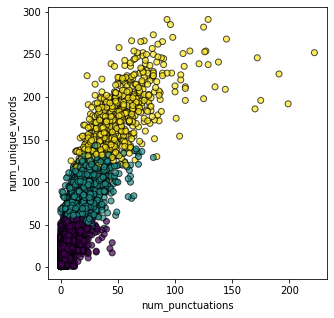

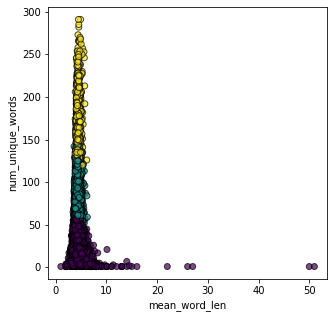

In [48]:
for column in df_for_clustering:
    #Plot the predictions
    plt.figure(figsize=[5,5])
    plt.scatter(x = df_for_clustering[column],
                y = df_for_clustering['num_unique_words'],
                c=pred_labels_kmm, 
                edgecolor='k',
                alpha=0.7)
    
    plt.xlabel(column)
    plt.ylabel('num_unique_words')
    plt.show();

#### TSNE Model

In [49]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [51]:
# tSNE with two components
X = df_for_clustering
y = df_for_clustering['star_rating']

# We need to scale the data since tSNE is also distance based
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

my_tSNE = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

X_tSNE = my_tSNE.fit_transform(X_scaled)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 18405 samples in 0.011s...
[t-SNE] Computed neighbors for 18405 samples in 1.131s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18405
[t-SNE] Computed conditional probabilities for sample 2000 / 18405
[t-SNE] Computed conditional probabilities for sample 3000 / 18405
[t-SNE] Computed conditional probabilities for sample 4000 / 18405
[t-SNE] Computed conditional probabilities for sample 5000 / 18405
[t-SNE] Computed conditional probabilities for sample 6000 / 18405
[t-SNE] Computed conditional probabilities for sample 7000 / 18405
[t-SNE] Computed conditional probabilities for sample 8000 / 18405
[t-SNE] Computed conditional probabilities for sample 9000 / 18405
[t-SNE] Computed conditional probabilities for sample 10000 / 18405
[t-SNE] Computed conditional probabilities for sample 11000 / 18405
[t-SNE] Computed conditional probabilities for sample 12000 / 18405
[t-SNE] Computed conditional probabilities for sa

In [103]:
df_for_clustering['star_rating'].value_counts()

5    9869
1    3576
4    3536
2    1424
Name: star_rating, dtype: int64

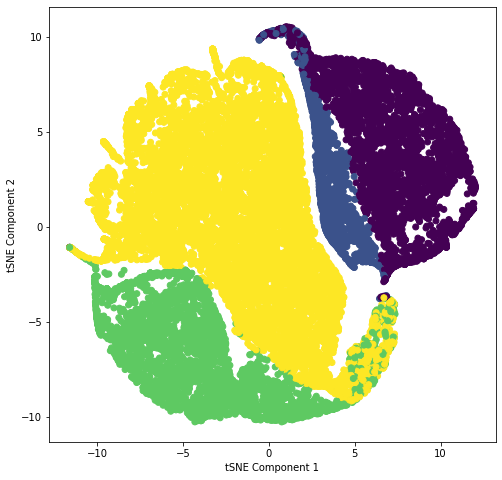

In [52]:
# Plotting the tSNE-transformed data (only the first two dimensions)
plt.figure(figsize=(8, 8))
plt.scatter(X_tSNE[:,0],X_tSNE[:,1],c=y)

plt.xlabel("tSNE Component 1")
plt.ylabel("tSNE Component 2")

plt.show()

From this plot we can clearly see how all the samples are nicely spaced apart and grouped together with their respective digits. This could be an amazing starting point to then use a clustering algorithm and try to identify the clusters or to actually use these two dimensions as input to another algorithm (e.g., something like a Neural Network).

Next Steps:
- Using NLP try clustering the "common phrases"

## Misc.

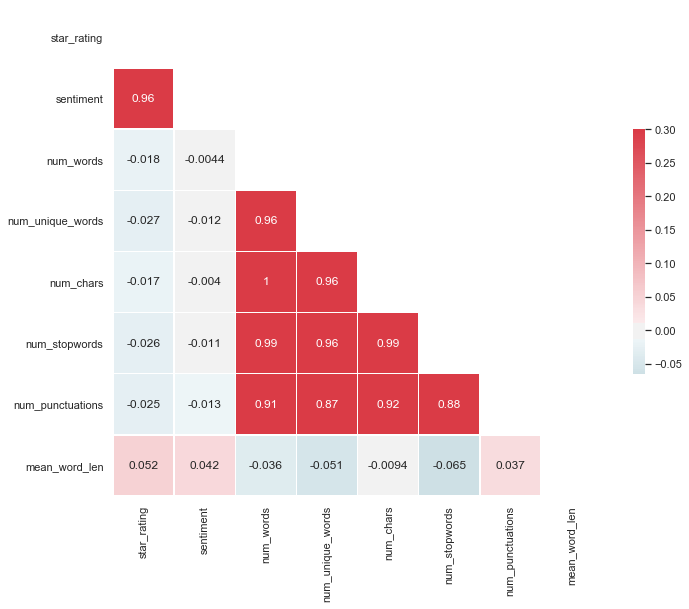

In [179]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=corr)

In [169]:
df1 = df_small

In [172]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
#Lets take a look at the Varience Inflation Factor on ONLY low corrolated columns
VIF = []

df_small = df1.drop('num_words', axis=1)

for i in df_small:
    X = df_small[[
        'star_rating',
        'sentiment',
#         'num_words',
        'num_unique_words',
        "num_chars",
        'num_stopwords'
       
        ]]
    
    low_vif_df = X
    y = df['sentiment']
    
    X_withconst = sm.add_constant(X)
    
    #Lets store our results
    VIF = pd.Series([variance_inflation_factor(X.values, i) 
        for i in range(X.shape[1])],index=X.columns)
    
    #Lets make a pretty table to show our results
    pd.options.display.float_format = '{:.2f}'.format
    
VIF_Frame = pd.DataFrame(VIF, columns=['VIF Value'])

VIF_Frame

,VIF Value
star_rating,34.24
sentiment,29.19
num_unique_words,23.78
num_chars,60.44
num_stopwords,57.09


In [79]:
# seaborn uses the average linkage by default
# sns.clustermap(df_pair_plot, col_cluster=False);

In [186]:
#Violin Plots
# f, axes = plt.subplots(3, 1, figsize=(10,20))
# sns.violinplot(x='sentiment', y='num_words', data=df_small, ax=axes[0])
# axes[0].set_xlabel('Sentiment', fontsize=12)
# axes[0].set_title("Number of words in each class", fontsize=15)

# sns.violinplot(x='sentiment', y='num_chars', data=df_small, ax=axes[1])
# axes[1].set_xlabel('Sentiment', fontsize=12)
# axes[1].set_title("Number of characters in each class", fontsize=15)

# sns.violinplot(x='sentiment', y='num_punctuations', data=df_small, ax=axes[2])
# axes[2].set_xlabel('Sentiment', fontsize=12)
# axes[2].set_title("Number of punctuations in each class", fontsize=15)
# plt.show()

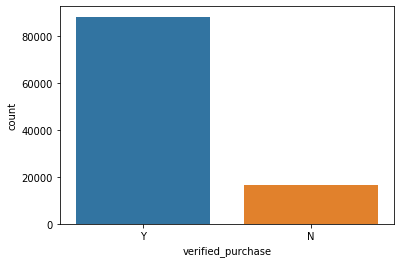

In [126]:
sns.countplot(x='verified_purchase', data=df)

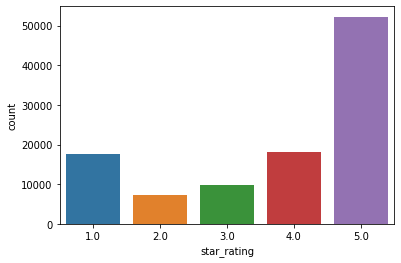

In [127]:
sns.countplot(x='star_rating', data=df)

In [228]:
# df_for_plot = df.sample(frac=.05, random_state=42)
# a = sns.FacetGrid(df_for_plot, col="star_rating", row="verified_purchase")
# a.map(plt.hist, "verified_purchase", alpha=1)
# # a.add_legend();

In [119]:
df_cluster = df_for_cluster

In [124]:
from sklearn.cluster import KMeans

#Specify the model
k_means_model = KMeans(n_clusters = 4)
#Fit the model to the data
k_means_model.fit(df_for_cluster);

ValueError: could not convert string to float: 'N'

Thoughts
- Just because you have trustworthy reviews, doesn't mean you'll get a good product.

Trustworthy reviews
 - Longer
 - Amazon Verified Purchase
 - Ratio of Reviews is 10 one stars for every 90 five stars
 - Number of words in 'superlative' Dictionary is high. (Kind of like stop words)
 - Good grammer and punctuation.
 
Endgame
 - Be able to count the number of products a store has
 - Have a "Country of Sale Origin" Indicating where you'll be getting the product from.

### Handling imbalanced datasets

Here you can see we have a larger number of `positive` samples vs. `negative` ones. There are a number of techniques to blance this dataset out and the two most popular approaches are to either under-sample or over-sample. With under sampling you remove rows to balance the dataset out and in over sampling you can duplicate entries in the daatset which could lead to overfitting. This discussion is beyond the scope of this lab. You will under sample the data to balance the dataset but you can find more information [here]().

1    24557
0    24557
Name: sentiment, dtype: int64


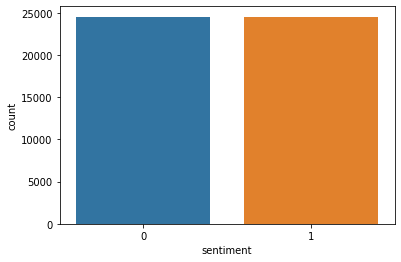

In [34]:
from sklearn.utils import resample

positive = df[df['sentiment']==1]
negative = df[df['sentiment']==0]

positive_downsampled = resample(positive,
                                replace = False, # sample without replacement
                                n_samples = len(negative), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([positive_downsampled, negative])

# checking counts
print(downsampled['sentiment'].value_counts())
sns.countplot(x='sentiment', data=downsampled)

### Export datasets

In [35]:
import csv 

file_name = 'reviews.csv'
final_df = downsampled.loc[:, ['review_body', 'star_rating', 'sentiment']]
final_df['review_body'] = downsampled['review_body'].astype('str')
final_df.to_csv("reviews.csv", index=False, header=False, quoting=csv.QUOTE_ALL, escapechar='\\', doublequote=False)

### Unlabeled Data

We will also create a dataset here with the reviews only. This will simulate not having labelled data for training and in a follow up lab you will be able to use [SageMaker Ground Truth](https://aws.amazon.com/sagemaker/groundtruth/) to build up a labeled dataset for training.

In [36]:
gt_df = downsampled.loc[:, ['review_body']]
gt_df.to_csv("groundtruth.csv", index=False, header=True)

In [37]:
unlabeled_df = pd.read_csv('groundtruth.csv', error_bad_lines=False)
unlabeled_df.head()

,review_body
0,i purchased the black i touch case for my husband ipod he was very impressed with it. i though it was very cute! it fit fine and the design of the tire track made it more sporty. i jus love it.
1,"product seems very quality constructed. love the flip style multi angle adjustable case and leather cover. had a more conventional side opening cover made of ""pleather"" (synthetic), used it for a year prior to purchasing this product."
2,the ismooth cable works wonderful and great. it looks just like an apple product. very long just as described. i love it!!!
3,this was all i needed for my zune player. the price was right. i would recommend this as a package deal.
4,this is a great buy! easy to program. looks like a knock off but functions like oem. my dog licks his pee pee.


### [Upload to S3](https://docs.aws.amazon.com/AmazonS3/latest/dev/Welcome.html)

Next, we will upload the files you created above to S3 to be used in a later workshop.

[s3.upload_file](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3.html#S3.Client.upload_file) boto3 documentation

In [38]:
s3_resource.Bucket(bucket).Object(os.path.join('raw', file_name)).upload_file(file_name)
s3_resource.Bucket(bucket).Object(os.path.join('unlabeled', 'groundtruth.csv')).upload_file('groundtruth.csv')

### List S3 Bucket Contents

Now that we have uploaded objects to our S3 bucket we can view the contents of the bucket as well through the SDK.

In [39]:
paginator = s3.get_paginator('list_objects_v2')
for result in paginator.paginate(Bucket=bucket):
    if result.get('Contents') is not None:
        for files in result.get('Contents'):
            if not files.get('Key') == "":
                print(files.get('Key'))

raw/reviews.csv
unlabeled/groundtruth.csv


### Create test, train, and validate datasets for training

Depending on the framework you are leveraging in your AI/ML workloads you may decide to split the data into test, train, and validate splits before uploading to S3. You can leverage some built in functions in the sklearn package to do the split. To learn more about the sklearn framework click [here](https://scikit-learn.org/stable/).

In [40]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(final_df, test_size=0.2, random_state=0)
train, validate = train_test_split(train, test_size=0.2, random_state=0)

print(f'Number of training examples: {len(train.index)}')
print(f'Number of validation examples: {len(validate.index)}')
print(f'Number of testing examples: {len(test.index)}')

Number of training examples: 31432
Number of validation examples: 7859
Number of testing examples: 9823


In [41]:
train.to_csv("train.csv", index=False, header=False, quoting=csv.QUOTE_NONE, escapechar='\\')
test.to_csv("test.csv", index=False, header=False, quoting=csv.QUOTE_NONE, escapechar='\\')
validate.to_csv("validate.csv", index=False, header=False, quoting=csv.QUOTE_NONE, escapechar='\\')

## Misc.

### [Upload to S3](https://docs.aws.amazon.com/AmazonS3/latest/dev/Welcome.html)

Now let's upload the splits created above to S3.

[s3.upload_file](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3.html#S3.Client.upload_file) boto3 documentation

In [42]:
s3_resource.Bucket(bucket).Object(os.path.join('data', 'train.csv')).upload_file('train.csv')
s3_resource.Bucket(bucket).Object(os.path.join('data', 'test.csv')).upload_file('test.csv')
s3_resource.Bucket(bucket).Object(os.path.join('data', 'validate.csv')).upload_file('validate.csv')

### Democratizing Data

You may determine that you want to make this dataset available to your lab or team to give them the ability to perform their own research on this same dataset. You can utilize a number of services in the [AWS Data Lakes & Analytics](https://aws.amazon.com/big-data/datalakes-and-analytics/) group to do so. This is the start of building out a [Data Lake on AWS](https://aws.amazon.com/big-data/datalakes-and-analytics/what-is-a-data-lake/?nc=sn&loc=2). We will start by cataloging the raw data in the Glue Data Catalog which is a Hive compliant metadata repository.


### Create the [AWS Glue Catalog Database](https://docs.aws.amazon.com/glue/latest/dg/define-database.html)

When you define a table in the AWS Glue Data Catalog, you add it to a database. A database is used to organize tables in AWS Glue. You can organize your tables using a crawler or using the AWS Glue console. A table can be in only one database at a time.

There is a central Glue Catalog for each AWS account. When creating the database you will use your account id declared above as `account_id`

[glue.create_database](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/glue.html#Glue.Client.create_database)

In [43]:
def create_database(glue_client, account_id, database_name, description):
    """Create the specified Glue database if it does not exist"""
    try:
        glue_client.get_database(
            CatalogId=account_id,
            Name=database_name
        )
    except glue_client.exceptions.EntityNotFoundException:
        print("Creating database: %s" % database_name)
        glue_client.create_database(
            CatalogId=account_id,
            DatabaseInput={
                'Name': database_name,
                'Description': description
            }
        )

In [44]:
database_name = 'reviews'
create_database(glue, account_id, database_name, 'Database for Amazon Reviews')

Creating database: reviews


### [Create the Raw table in Glue](https://docs.aws.amazon.com/glue/latest/dg/tables-described.html)

When you define a table in AWS Glue, you also specify the value of a classification field that indicates the type and format of the data that's stored in that table. If a crawler creates the table, these classifications are determined by either a built-in classifier or a custom classifier. If you create a table manually in the console or by using an API, you specify the classification when you define the table. For more information about creating a table using the AWS Glue console, see [Working with Tables on the AWS Glue Console](https://docs.aws.amazon.com/glue/latest/dg/console-tables.html).

[glue.create_table](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/glue.html#Glue.Client.create_table)

In [45]:
location = 's3://{0}/raw/'.format(bucket)
raw_table_name = 'raw'

response = glue.create_table(
    CatalogId=account_id,
    DatabaseName=database_name,
    TableInput={
        'Name': raw_table_name,
        'Description': 'Raw Amazon Mobile Products reviews',
        'StorageDescriptor': {
            'Columns': [                
                {
                    'Name': 'review_body',
                    'Type': 'string',
                    'Comment': 'Review text of from the review'
                },         
                {
                    'Name': 'star_rating',
                    'Type': 'float',
                    'Comment': 'Star rating of from the review'
                },
                {
                    'Name': 'sentiment',
                    'Type': 'tinyint',
                    'Comment': 'Sentiment based on the star rating of from the review'
                }
            ],
            'Location': location,
            'InputFormat': 'org.apache.hadoop.mapred.TextInputFormat',
            'OutputFormat': 'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat',
            'SerdeInfo': {
                'SerializationLibrary': 'org.apache.hadoop.hive.serde2.OpenCSVSerde',
                'Parameters': {
                    'escapeChar': '\\',
                    'separatorChar': ',',
                    'serialization.format': '1'
                }
            },
        },
        'TableType': 'EXTERNAL_TABLE',
        'Parameters': {
            'classification': 'csv'
        }
    }
)

### [Query Raw Amazon Reviews with Athena ](https://docs.aws.amazon.com/athena/latest/ug/getting-started.html)

To see the raw reviews we will be installing a python library for querying the data in the Glue Data Catalog with Athena. More information about [PyAthena](https://pypi.org/project/PyAthena/) or available [ANSI SQL and DDL commands with Athena](https://docs.aws.amazon.com/athena/latest/ug/ddl-sql-reference.html)

In [46]:
!pip install PyAthena

     |████████████████████████████████| 52 kB 2.0 MB/s eta 0:00:01


In [47]:
from pyathena import connect
from pyathena.util import as_pandas

cursor = connect(region_name=region, s3_staging_dir='s3://{0}/temp'.format(bucket)).cursor()
cursor.execute('select * from {0}.{1} limit 10'.format(database_name, raw_table_name))

df = as_pandas(cursor)
df.head(5)

,review_body,star_rating,sentiment
0,i purchased the black i touch case for my husband ipod he was very impressed with it. i though it was very cute! it fit fine and the design of the tire track made it more sporty. i jus love it.,5.0,1
1,"product seems very quality constructed. love the flip style multi angle adjustable case and leather cover. had a more conventional side opening cover made of ""pleather"" (synthetic), used it for a year prior to purchasing this product.",5.0,1
2,the ismooth cable works wonderful and great. it looks just like an apple product. very long just as described. i love it!!!,5.0,1
3,this was all i needed for my zune player. the price was right. i would recommend this as a package deal.,5.0,1
4,this is a great buy! easy to program. looks like a knock off but functions like oem. my dog licks his pee pee.,5.0,1


In [48]:
cursor.execute('select count(1) as count, star_rating from {0}.{1} group by star_rating'.format(database_name, raw_table_name))

df = as_pandas(cursor)
df

,count,star_rating
0,6482,4.0
1,17322,1.0
2,18075,5.0
3,7235,2.0


### Optional - SQL Magic in Jupyter Notebooks

You can use the built-in functionality in Jupyter to create shortcut magic commands to fit your needs. Here we will use the pyathena library like above to query the review data, but this time we will encapsulate the call in the Jupyter magic command.

In [49]:
import pyathena
from pyathena.util import as_pandas

from IPython.core import magic_arguments
from IPython.core.magic import cell_magic, Magics, magics_class


def query_athena(sql, region_name, s3_staging_dir):
    cursor = pyathena.connect(
        region_name=region_name,
        s3_staging_dir="{}".format(s3_staging_dir)).cursor()
    cursor.execute(sql)
    return cursor

@magics_class
class AthenaMagics(Magics):
    s3_staging_dir = None
    region_name = None

    
    def parse_args(self, line):
        args = magic_arguments.parse_argstring(self.athena, line)

        # s3 staging directory
        if args.s3_staging_dir is None and self.s3_staging_dir is None:
            raise ValueError("s3_staging_dir for Athena should be set")
        if args.s3_staging_dir is not None:
            self.s3_staging_dir = args.s3_staging_dir
 
        # region name
        if args.region_name is None and self.region_name is None:
            raise ValueError("region_name for Athena should be set")
        if args.region_name is not None:
            self.region_name = args.region_name
 
    @cell_magic
    @magic_arguments.magic_arguments()
    @magic_arguments.argument('--s3_staging_dir', '-s',
        help='s3 path required by athena for writing query results (e.g. s3://your/staging/dir)'
    )
    @magic_arguments.argument('--region_name', '-r',
        help='aws region name (e.g. us-west-2)'
    )
    def athena(self, line='', cell=None):
        self.parse_args(line)
        cursor = query_athena(cell, self.region_name, self.s3_staging_dir)
        return as_pandas(cursor)

    
ip = get_ipython()
ip.register_magics(AthenaMagics)

In [50]:
print(region)
print("s3://{0}/temp".format(bucket))

us-east-1
s3://escience-workshop-dp/temp


Now that the magic is registered you can use the `%%athena` magic to query data registered in your Glue Data Catalog.
**Replace the {{region}} and {{bucket/temp}} with the region and bucket variable values above Ex.**

%%athena -r us-west-2 -s s3://escience-workshop/temp

In [51]:
%%athena -r us-east-1 -s s3://escience-workshop-dp/temp
select * 
from reviews.raw limit 10;

,review_body,star_rating,sentiment
0,i purchased the black i touch case for my husband ipod he was very impressed with it. i though it was very cute! it fit fine and the design of the tire track made it more sporty. i jus love it.,5.0,1
1,"product seems very quality constructed. love the flip style multi angle adjustable case and leather cover. had a more conventional side opening cover made of ""pleather"" (synthetic), used it for a year prior to purchasing this product.",5.0,1
2,the ismooth cable works wonderful and great. it looks just like an apple product. very long just as described. i love it!!!,5.0,1
3,this was all i needed for my zune player. the price was right. i would recommend this as a package deal.,5.0,1
4,this is a great buy! easy to program. looks like a knock off but functions like oem. my dog licks his pee pee.,5.0,1
5,bought this from seller as my cassette adapter was continuously ejecting itself. found the right station and this thing works like a dream,5.0,1
6,i am so glad i bought this usb charger for my husband! works great and my husband has finally stopped blasting the music on the computer and switched to listening to his charged ipod with headphones!! i couldnt be happier haha.... i should have gotten it sooner!,5.0,1
7,this pink nook cover is well made and very durable. the art decals and protector is all the rage for nook holders. keep these deals around.,5.0,1
8,"already have a bike computer by garmin, and bought this sensor for a second bike. it is a good quality product, precise, and sincs easily. helps keeping personal stats, no matter wich bike i have to use. love it...!",5.0,1
9,"we ordered this for my daughter's nook color she got for christmas. we looked at several at local retailers and settled in for this. not only do you get a lot for the money (about 25% of what it would have cost at barnes & noble). the sticker frame fit perfect, the book cover as well, the screen cover worked great (once we got one that wasn't damaged). we had to request replacement screen protectors twice. both were damaged in shipping. poor packaging, needs a protective sleeve for shipping. once we got one that wasn't damaged we are very happy. definitely worth every little penny spent. my daughter is 8 and it has held up great. you pick the color that suits you, but definitely get this and save the money over the store stuff, way over priced in store.",5.0,1


You have successfully completed this lab!!!! 

In this lab you learned to store and retrieve objects with S3, do data manipulation with a number of tools in python like pandas, seaborn, and sklearn, and register and query data in AWS to start building out a dat lake to democratize access to datasets for machine learning.

### Cleanup